# Okavango_Scenario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.patches as patches
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from hydroeval import evaluator, nse, rmse, pbias
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


# Set Path

In [2]:
wd_scn = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_scn_bau"
wd_base = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_calibrated_base"
wd_rd = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_scn_RD"
# os.chdir(wd)



# Create Dataframe from output.rch

## BAU

In [13]:
ress = [48]
scn_137 = pd.read_csv(
                    os.path.join(wd_scn, "output.rsv"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 2, 5], # streamflow
                    usecols=[1, 2, 10], # sediment
                    names=["res_no", "filter", "scn_137"],
                    index_col=0)
scn_137 = scn_137.loc[48]
scn_137 = scn_137[scn_137["filter"] < 13]
scn_137.index = pd.date_range('1/1/2003', periods=len(scn_137.scn_137), freq="M")

scn_240 = pd.read_csv(
                    os.path.join(wd_scn, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # streamflow
                    names=["date", "filter", "scn_240"],
                    index_col=0)
scn_240 = scn_240.loc[240]
scn_240 = scn_240[scn_240["filter"] < 13]
scn_240.index = pd.date_range('1/1/2003', periods=len(scn_240.scn_240), freq="M")


In [14]:
scn_137

,filter,scn_137
2003-01-31,1,829000.00
2003-02-28,2,489200.00
2003-03-31,3,880500.00
2003-04-30,4,1434000.00
2003-05-31,5,504600.00
...,...,...
2019-08-31,8,0.00
2019-09-30,9,0.00
2019-10-31,10,0.00
2019-11-30,11,0.00


In [15]:
scn_240

,filter,scn_240
2003-01-31,1.0,108400.0
2003-02-28,2.0,136700.0
2003-03-31,3.0,136700.0
2003-04-30,4.0,169600.0
2003-05-31,5.0,182000.0
...,...,...
2019-08-31,8.0,23290.0
2019-09-30,9.0,17050.0
2019-10-31,10.0,15160.0
2019-11-30,11.0,19040.0


In [16]:
scn_df = pd.concat([scn_137, scn_240], axis=1)
scn_dff = scn_df.groupby(scn_df.index.month).mean()
# scn_df_aa = scn_df.resample('A').mean()
# scn_df_as = scn_df.resample('A').sum() * 86400
scn_dff = scn_dff.drop('filter', axis=1)
scn_dff

,scn_137,scn_240
1,481191.952941,91095.294118
2,358679.900000,123835.294118
3,689805.811765,152307.058824
4,749850.917647,169960.000000
5,274591.191176,133457.647059
6,216368.614706,58903.529412
7,250688.968824,47638.235294
8,287182.352941,38368.823529
9,325135.294118,28318.235294
10,389929.411765,27505.882353


## BASE

In [7]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_rch = pd.read_csv(
                    os.path.join(wd_base, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # sed
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_adj = pd.DataFrame()
for i in subs:
    df = df_rch.loc[i]
    df = df[df["filter"] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    df.rename(columns = {'streamflow_sim':'base_{}'.format(i)}, inplace = True)
    # df = df.drop('filter', axis=1)
    df_adj = pd.concat(
        [df_adj, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_adj.index = pd.DatetimeIndex(df_adj.index).normalize()



In [8]:
df_adj

,base_137,base_240
2003-01-31,194.400,342.90
2003-02-28,462.800,474.00
2003-03-31,344.000,499.30
2003-04-30,366.500,428.20
2003-05-31,125.300,416.50
...,...,...
2019-08-31,3.869,112.10
2019-09-30,2.669,88.16
2019-10-31,2.791,73.11
2019-11-30,5.841,102.60


In [9]:
base_df = df_adj.groupby(df_adj.index.month).mean()
base_df.index
base_df

,base_137,base_240
1,227.977059,287.429412
2,340.776471,433.352941
3,415.852941,474.958824
4,347.800000,472.135294
5,95.222353,356.500000
6,15.187176,219.470588
7,7.767471,170.976471
8,5.482529,146.070588
9,3.580118,125.305882
10,3.662529,119.374118


# RD

In [10]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_rch = pd.read_csv(
                    os.path.join(wd_rd, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    # usecols=[1, 3, 6], # streamflow
                    usecols=[1, 3, 10], # streamflow
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_rd = pd.DataFrame()
for i in subs:
    df = df_rch.loc[i]
    df = df[df['filter'] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    
    df.rename(columns = {'streamflow_sim':'base_{}'.format(i)}, inplace = True)
    df_rd = pd.concat(
        [df_rd, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_rd.index = pd.DatetimeIndex(df_rd.index).normalize()
df_rd = df_rd.groupby(df_rd.index.month).mean()
df_rd



,base_137,base_240
1,232.952941,284.276471
2,345.317647,432.047059
3,421.088235,473.941176
4,348.623529,470.794118
5,92.531765,351.558824
6,14.565412,212.958824
7,7.775647,166.111765
8,5.443824,142.870588
9,3.424353,121.765294
10,3.564529,114.398235


# Average Monthly Streamflow

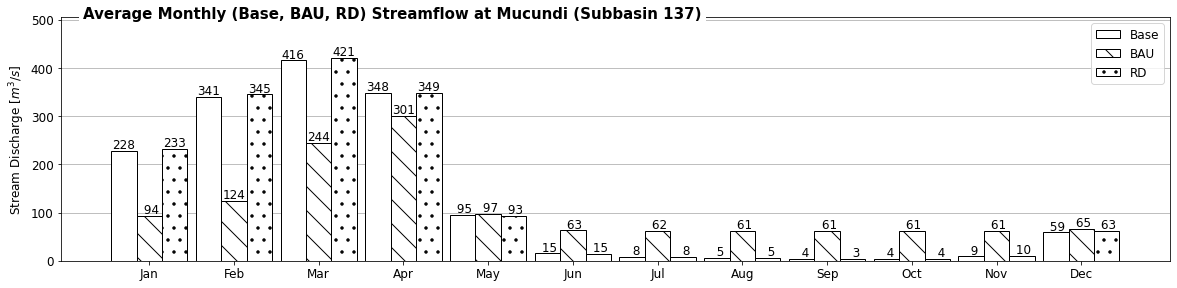

In [18]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_137, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, scn_dff.scn_137, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.base_137, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_137):
    ax.text(
        index-0.1, value+5, '{:3.0f}'.format(value),
        fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, scn_dff.scn_137):
    ax.text(index, value+5, '{:3.0f}'.format(value), fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, df_rd.base_137):
    ax.text(index+0.3, value+5, '{:3.0f}'.format(value), fontsize=12, rotation=0, horizontalalignment='center')


ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)
ax.margins(y=0.2)
ax.set_title(
    'Average Monthly (Base, BAU, RD) Streamflow at Mucundi (Subbasin 137)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
ax.set_ylabel(r'Stream Discharge $[m^3/s]$', fontsize = 12)
plt.savefig('am_mucundi_ff.png', dpi=300, bbox_inches="tight")
plt.show()

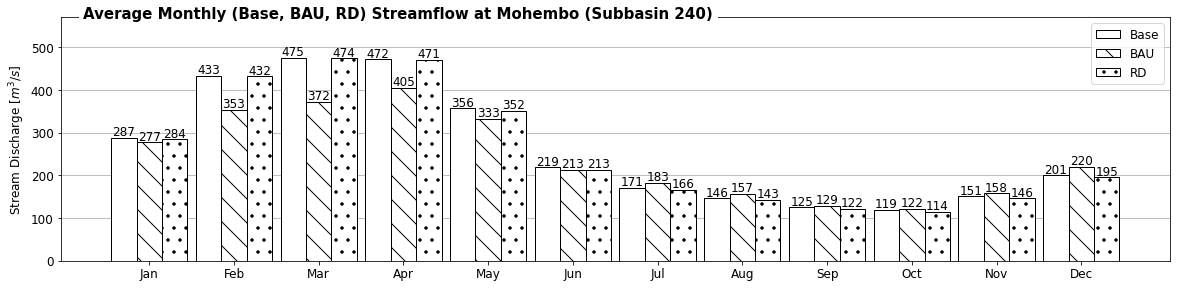

In [11]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_240, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, scn_dff.scn_240, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.base_240, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_240):
    ax.text(
        index-0.1, value+5, '{:3.0f}'.format(value),
        fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, scn_dff.scn_240):
    ax.text(index, value+5, '{:3.0f}'.format(value), fontsize=12, rotation=0, horizontalalignment='center')
for index, value in zip(base_df.index, df_rd.base_240):
    ax.text(index+0.3, value+5, '{:3.0f}'.format(value), fontsize=12, rotation=0, horizontalalignment='center')

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)


ax.margins(y=0.2)
ax.set_title(
    'Average Monthly (Base, BAU, RD) Streamflow at Mohembo (Subbasin 240)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
ax.set_ylabel(r'Stream Discharge $[m^3/s]$', fontsize = 12)
plt.savefig('am_mohembo_ff.png', dpi=300, bbox_inches="tight")
plt.show()

In [12]:
os.getcwd()

'd:\\spark-brc_gits\\swatmf_git'

# Create Dataframe from output.sub

## 1. Base

In [125]:
colnum = 11
colnam = 'swgw'
ylabel = "GW-SW Interaction"


In [126]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_base, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    index_col=0)

df_adj = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="D")
    df.rename(columns = {colnam:'base_{}'.format(i)}, inplace = True)
    df_adj = pd.concat(
        [df_adj, df['base_{}'.format(i)]], axis=1,
        sort=False
        )
df_adj.index = pd.DatetimeIndex(df_adj.index).normalize()

In [127]:
base_df = df_adj.groupby(df_adj.index.month).mean()
base_df

,base_137,base_240
1,0.619282,0.825287
2,0.886357,0.888221
3,1.087720,0.939370
4,0.688315,0.910033
5,0.048857,0.801512
6,-0.131072,0.757476
7,-0.157161,0.718894
8,-0.176102,0.661070
9,-0.159205,0.602294
10,-0.182425,0.561252


## 2. BAU

In [128]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_scn, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    index_col=0)

df_scn = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="D")
    df.rename(columns = {colnam:'scn_{}'.format(i)}, inplace = True)
    df_scn = pd.concat(
        [df_scn, df['scn_{}'.format(i)]], axis=1,
        sort=False
        )
df_scn.index = pd.DatetimeIndex(df_scn.index).normalize()

In [129]:
df_scn = df_scn.groupby(df_scn.index.month).mean()
df_scn

,scn_137,scn_240
1,0.630952,0.830004
2,0.895458,0.891735
3,1.081304,0.931639
4,0.647199,0.897229
5,0.053834,0.808224
6,-0.124577,0.766225
7,-0.155297,0.725104
8,-0.175317,0.670873
9,-0.159208,0.610553
10,-0.182528,0.566664


# 3. RD

In [130]:
# Select subs
subs = [137, 240]

# Create data with parameter change
df_sub = pd.read_csv(
                    os.path.join(wd_rd, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, colnum],
                    names=["date", "filter", colnam],
                    dtype = {'filter': str},
                    index_col=0)

df_rd = pd.DataFrame()
for i in subs:
    df = df_sub.loc[i]
    # df = df[(df["filter"].astype(str).map(len)) <= 13]
    df.index = pd.date_range('1/1/2003', periods=len(df[colnam]), freq="D")
    df.rename(columns = {colnam:'rd_{}'.format(i)}, inplace = True)
    df_rd = pd.concat(
        [df_rd, df['rd_{}'.format(i)]], axis=1,
        sort=False
        )
df_rd.index = pd.DatetimeIndex(df_rd.index).normalize()

In [131]:
df_rd = df_rd.groupby(df_rd.index.month).mean()
df_rd

,rd_137,rd_240
1,0.619282,0.825287
2,0.886367,0.888221
3,1.087722,0.939370
4,0.688315,0.910033
5,0.048856,0.801516
6,-0.131075,0.757471
7,-0.157178,0.718892
8,-0.176102,0.661072
9,-0.159205,0.602296
10,-0.182425,0.561250


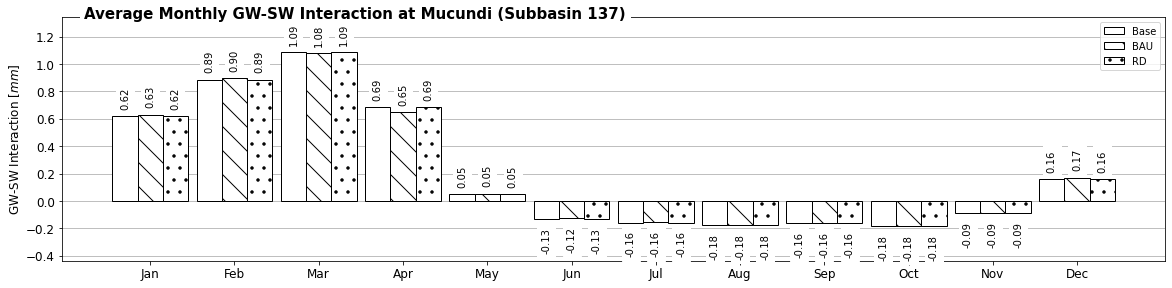

In [142]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_137, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, df_scn.scn_137, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.rd_137, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)

for index, value in zip(base_df.index-0.2, base_df.base_137):
    if value > 0:
        ax.text(
            index-0.1, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
    else:
        ax.text(
            index-0.1, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
for index, value in zip(base_df.index, df_scn.scn_137):
    if value > 0:
        ax.text(
            index, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )
    else:
        ax.text(
            index, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'                       
            )
for index, value in zip(base_df.index, df_rd.rd_137):
    if value > 0:
        ax.text(
            index+0.3, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white', 
            horizontalalignment='center'           
            )
    else:
        ax.text(
            index+0.3, value-0.25, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)
ax.margins(y=0.2)
ax.set_title(
    'Average Monthly {} at Mucundi (Subbasin 137)'.format(ylabel),
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=10)
ax.grid(axis='y', zorder=0)
ax.set_ylabel('{} $[mm]$'.format(ylabel), fontsize = 12)
plt.savefig('am_mucundi_{}.png'.format(colnam), dpi=300, bbox_inches="tight")
plt.show()

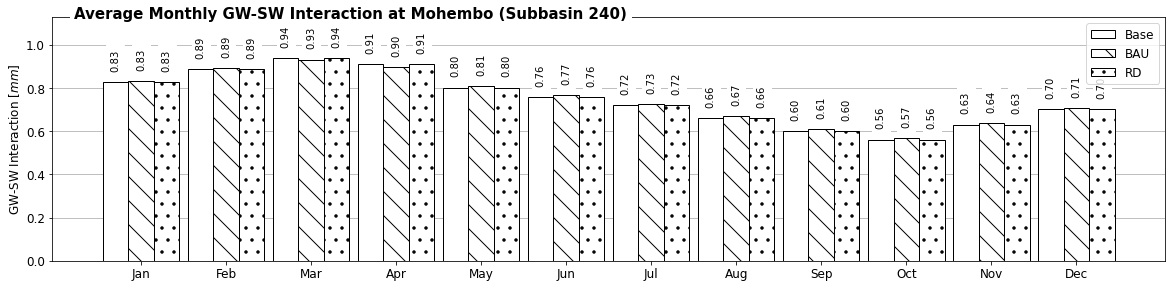

In [143]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(16,4)
                )
# x = date2num(base_df.index)
w = 0.3
ax.bar(base_df.index-0.3, base_df.base_240, width=w, align='center', label='Base', hatch='', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index, df_scn.scn_240, width=w, align='center', label='BAU', hatch='\\', color='white', edgecolor='black', zorder=3)
ax.bar(base_df.index+0.3, df_rd.rd_240, width=w, align='center', label='RD', hatch='.', color='white', edgecolor='black', zorder=3)


for index, value in zip(base_df.index-0.2, base_df.base_240):
    if value > 0:
        ax.text(
            index-0.1, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
    else:
        ax.text(
            index-0.1, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'
            )
for index, value in zip(base_df.index, df_scn.scn_240):
    if value > 0:
        ax.text(
            index, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )
    else:
        ax.text(
            index, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'                       
            )
for index, value in zip(base_df.index, df_rd.rd_240):
    if value > 0:
        ax.text(
            index+0.3, value+0.05, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white', 
            horizontalalignment='center'           
            )
    else:
        ax.text(
            index+0.3, value-0.1, '{:3.2f}'.format(value), fontsize=10,
            verticalalignment='bottom', rotation=90,
            backgroundcolor='white',
            horizontalalignment='center'            
            )


ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(base_df.index[::1])
# ax.xaxis_date()
# plt.xticks[1].set_visible(False)
ax.set_xticks(base_df.index[::1])
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(month_names)


ax.margins(y=0.2)
ax.set_title(
    'Average Monthly {} at Mohembo (Subbasin 240)'.format(ylabel),
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y', zorder=0)
ax.set_ylabel('{} $[mm]$'.format(ylabel), fontsize = 12)
plt.savefig('am_mohembo_{}.png'.format(colnam), dpi=300, bbox_inches="tight")
plt.show()

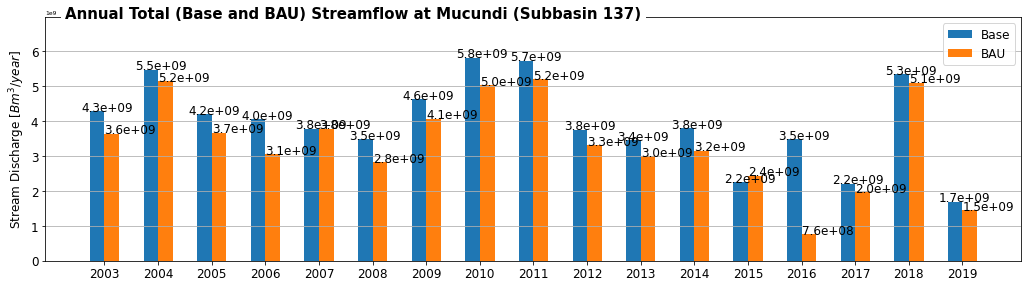

In [26]:
fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(14,4)
                )
x = date2num(df_base_as.index)
w = 100
ax.bar(x-50, df_base_as.sub_137, width=w, align='center', label='Base')
ax.bar(x+50, scn_df_as.res_sim, width=w, align='center', label='BAU')
for index, value in zip(x, scn_df_as.res_sim):
    ax.text(index, value+5, '{:1.1e}'.format(value), fontsize=12)
for index, value in zip(x-160, df_base_as.sub_137):
    ax.text(index, value+5, '{:1.1e}'.format(value), fontsize=12)

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
ax.set_xticks(x[::1])
ax.xaxis_date()
# plt.xticks[1].set_visible(False)

ax.margins(y=0.2)
ax.set_title(
    'Annual Total (Base and BAU) Streamflow at Mucundi (Subbasin 137)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y')
ax.set_ylabel(r'Stream Discharge $[Bm^3/year]$', fontsize = 12)
plt.savefig('as_mucundi.png', dpi=300, bbox_inches="tight")
plt.show()

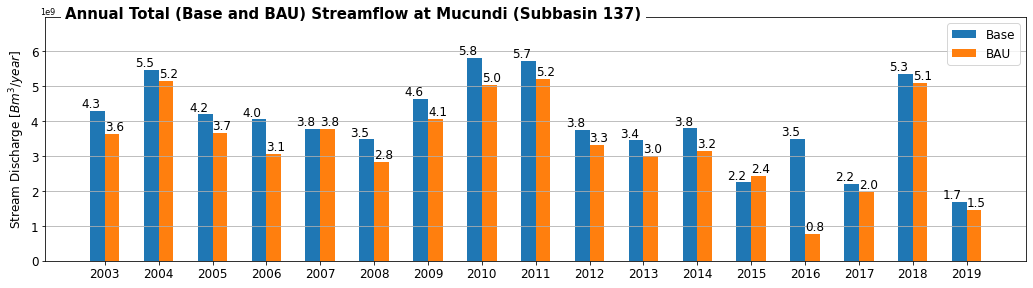

In [25]:
df_base_as_ = df_base_as/(1e9)
scn_df_as_ = scn_df_as/(1e9)

fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(14,4)
                )
x = date2num(df_base_as.index)
w = 100
ax.bar(x-50, df_base_as_.sub_137, width=w, align='center', label='Base')
ax.bar(x+50, scn_df_as_.res_sim, width=w, align='center', label='BAU')
for index, value in zip(x, scn_df_as_.res_sim):
    ax.text(index, value+0.1, '{:1.1f}'.format(value), fontsize=12)
for index, value in zip(x-160, df_base_as_.sub_137):
    ax.text(index, value+0.1, '{:1.1f}'.format(value), fontsize=12)

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
ax.set_xticks(x[::1])
ax.xaxis_date()
# plt.xticks[1].set_visible(False)

ax.margins(y=0.2)
ax.set_title(
    'Annual Total (Base and BAU) Streamflow at Mucundi (Subbasin 137)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
ax.text(-0.005, 1.01, '1e9', fontsize=8, transform=ax.transAxes)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y')
ax.set_ylabel(r'Stream Discharge $[Bm^3/year]$', fontsize = 12)
plt.savefig('as_mucundi.png', dpi=300, bbox_inches="tight")
plt.show()

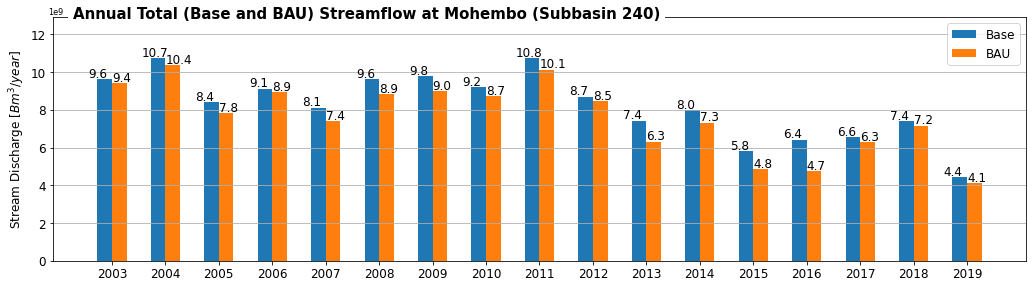

In [27]:
df_base_as_ = df_base_as/(1e9)
scn_df_as_ = scn_df_as/(1e9)

fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(14,4)
                )
x = date2num(df_base_as.index)
w = 100
ax.bar(x-50, df_base_as_.sub_240, width=w, align='center', label='Base')
ax.bar(x+50, scn_df_as_.str_sim, width=w, align='center', label='BAU')
for index, value in zip(x, scn_df_as_.str_sim):
    ax.text(index, value+0.1, '{:1.1f}'.format(value), fontsize=12)
for index, value in zip(x-160, df_base_as_.sub_240):
    ax.text(index, value+0.1, '{:1.1f}'.format(value), fontsize=12)

ax.tick_params(axis='both', labelsize=12)
# plt.setp(ax.get_xticklabels(), rotation=70)
ax.set_xticks(x[::1])
ax.xaxis_date()
# plt.xticks[1].set_visible(False)

ax.margins(y=0.2)
ax.set_title(
    'Annual Total (Base and BAU) Streamflow at Mohembo (Subbasin 240)',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.02,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
ax.text(-0.005, 1.01, '1e9', fontsize=8, transform=ax.transAxes)
plt.tight_layout()
ax.legend(fontsize=12)
ax.grid(axis='y')
ax.set_ylabel(r'Stream Discharge $[Bm^3/year]$', fontsize = 12)
plt.savefig('as_mohembo.png', dpi=300, bbox_inches="tight")
plt.show()

In [31]:
df_base_as

,sub_137,sub_240
2003-12-31,4.288306e+09,9.644340e+09
2004-12-31,5.477142e+09,1.073961e+10
2005-12-31,4.191854e+09,8.396577e+09
2006-12-31,4.048073e+09,9.123261e+09
2007-12-31,3.781227e+09,8.113660e+09
2008-12-31,3.475669e+09,9.624390e+09
2009-12-31,4.630120e+09,9.768807e+09
2010-12-31,5.814141e+09,9.219813e+09
2011-12-31,5.735433e+09,1.075570e+10
2012-12-31,3.757993e+09,8.704670e+09


In [35]:
scn_df_as = scn_df_as.rename({'str_sim': 'scn_240', 'res_sim': 'scn_137'}, axis=1)
scn_df_as = scn_df_as.drop('filter', axis=1)
scn_df_as

,scn_240,scn_137
2003-12-31,9.426300e+09,3.643842e+09
2004-12-31,1.037570e+10,5.150229e+09
2005-12-31,7.807571e+09,3.670690e+09
2006-12-31,8.928014e+09,3.059118e+09
2007-12-31,7.382915e+09,3.782759e+09
2008-12-31,8.850626e+09,2.827971e+09
2009-12-31,8.991156e+09,4.073892e+09
2010-12-31,8.717725e+09,5.035910e+09
2011-12-31,1.012676e+10,5.212151e+09
2012-12-31,8.477317e+09,3.313710e+09


In [52]:
df_as_tot = pd.concat([df_base_as, scn_df_as], axis=1)
df_as_tot_mean = df_as_tot.mean()
df_as_tot_mean_ = df_as_tot_mean/(1e9)
df_as_tot_mean_
base = df_as_tot_mean_.loc[['sub_137', 'sub_240']]
scn = df_as_tot_mean_.loc[['scn_137', 'scn_240']]
base

sub_137    3.965292
sub_240    8.243217
dtype: float64

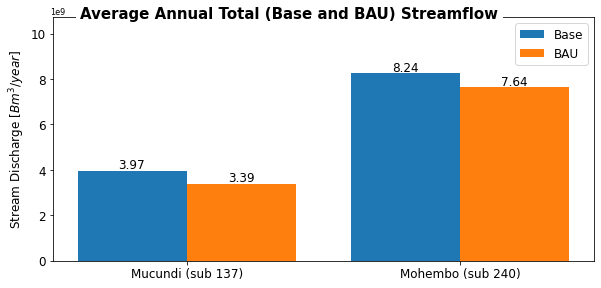

In [71]:


fig, ax = plt.subplots( 
                # sharex=True,
                figsize=(8,4)
                )

_X = np.arange(len(base.index))


ax.bar(_X-0.2, base, 0.4, label='Base')
ax.bar(_X+0.2, scn, 0.4, label='BAU')
plt.xticks(_X, ['Mucundi (sub 137)', 'Mohembo (sub 240)']) # set labels manually
# x = date2num(df_base_as.index)
# w = 100
# ax.bar(x-50, df_base_as_.sub_240, width=w, align='center', label='Base')
# ax.bar(x+50, scn_df_as_.str_sim, width=w, align='center', label='BAU')
for index, value in zip(_X-0.25, base):
    ax.text(index, value+0.1, '{:1.2f}'.format(value), fontsize=12)
for index, value in zip(_X+0.15, scn):
    ax.text(index, value+0.1, '{:1.2f}'.format(value), fontsize=12)

ax.tick_params(axis='both', labelsize=12)
# # plt.setp(ax.get_xticklabels(), rotation=70)
# ax.set_xticks(x[::1])
# ax.xaxis_date()
# # plt.xticks[1].set_visible(False)

ax.margins(y=0.3)
ax.set_title(
    'Average Annual Total (Base and BAU) Streamflow',
    fontsize=15,
    fontweight="bold",
    horizontalalignment='left',
    x=0.05,
    y=0.97,
    bbox=dict(
        facecolor='white',
        edgecolor='white'))
# ax.autoscale(tight=True)
ax.text(-0.005, 1.01, '1e9', fontsize=8, transform=ax.transAxes)
plt.tight_layout()
ax.legend(fontsize=12)
# ax.grid(axis='y')
ax.set_ylabel(r'Stream Discharge $[Bm^3/year]$', fontsize = 12)
plt.savefig('aat_okvg.png', dpi=300, bbox_inches="tight")
plt.show()